In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder
#from skimage.feature import greycomatrix,greycoprops

In [2]:
data_path = r'C:\Users\mmatr\Desktop\Learning Data Science\IBM Machine Learning\Git\IBM-Machine-Learning-Course\Course_5_Deep_Learning\NEU Metal Surface Defects Data'
os.chdir(data_path)


In [3]:
#code to acquaint with cv2. from tutorial on geeksforgeeks

# # path
# path = data_path + r'\test\Crazing\Cr_1.bmp'
  
# # Reading an image in grayscale mode
# image = cv2.imread(path, 0)
  
# # Window name in which image is displayed
# window_name = 'image'
  
# # Using cv2.imshow() method
# # Displaying the image
# cv2.imshow(window_name, image)
  
# # waits for user to press any key
# # (this is necessary to avoid Python kernel form crashing)
# cv2.waitKey(0)
  
# # closing all open windows
# cv2.destroyAllWindows()

I anticipate reuse of the following function to use the Train/Test/Validation Splits provided in the dataset.
However, these splits are unbalanced (1656/72/72), leading me to believe that a larger test set may be appropriate.


I will proceed by loading all of the data into a single dataset and using a 15% test train split.


In [4]:
def mse(a,b):
    """function to compute the mean square error between two numpy arrays"""
    return np.square(a-b).mean()

In [5]:
def load_images(data_path):
    """Function to load images from NEU Dataset"""

    images=[] 
    labels=[] 

    for dirpath, dirnames, filenames in os.walk(data_path):
        for filename in filenames:
            defect=dirpath.split('\\')[-1] 
            if '.bmp' in filename:
                images.append(cv2.imread(os.path.join(dirpath,filename),0))
                labels.append(defect)

    images=np.asarray(images)
    labels=np.asarray(labels)

    return images, labels

In [6]:
#load the data.
data, labels = load_images(data_path)

# train_images, train_labels = load_images(data_path + r'\train')
# val_images, val_labels = load_images(data_path + r'\valid')
# test_images, test_labels = load_images(data_path + r'\test')

In [7]:
#ensure labels came in correctly 
Counter(labels)


Counter({'Crazing': 300,
         'Inclusion': 300,
         'Patches': 300,
         'Pitted': 300,
         'Rolled': 300,
         'Scratches': 300})

Gray Scale intensities range from 0-255. 

The baseline classifier for this project is simply a comparison of contrast distribution in each image.  The normalized pixel intensity for each class will be calculated and displayed on a connected scatter plot.  Then, the mean square error (MSE) of each individual image will be computed with respect to the normalized intensities for each class.  The class the yields the lowest MSE will be the prediction for that image. 

Limitation of this method include:

Image quality. Even among images in the same class, background intensities vary significantly.  Also, I am using the whole dataset to "train" this model, meaning every image I attempt to classify has already been seen.  

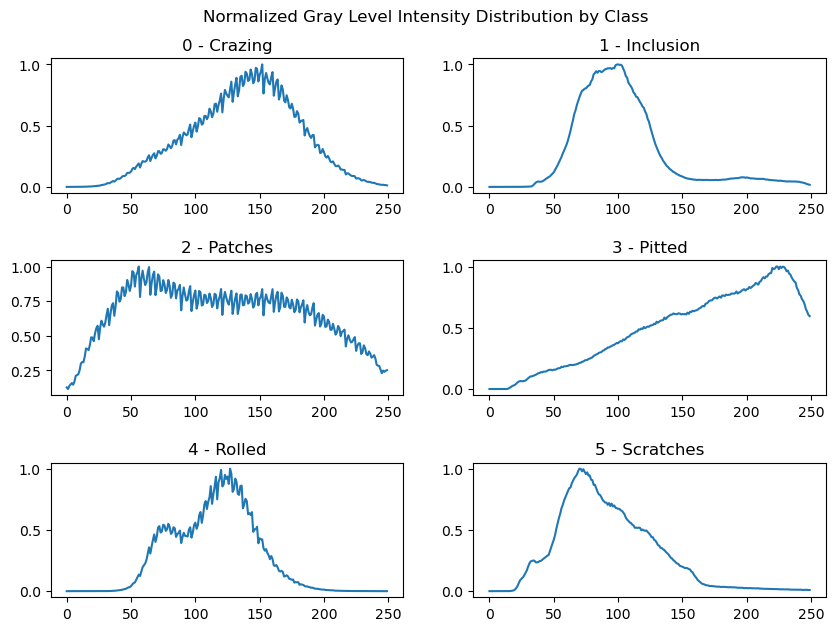

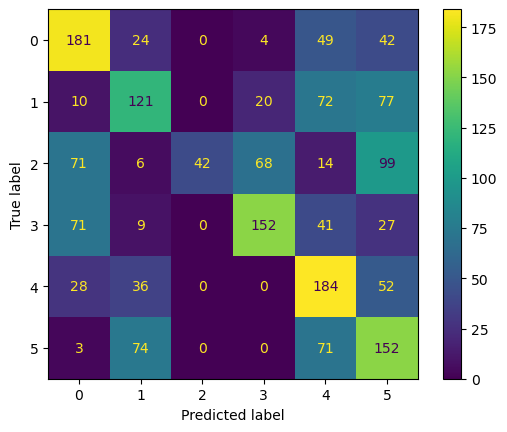

number of correct predictions =  832
total samples =  1800
accuracy =  0.4622222222222222


In [8]:
fig, axs = plt.subplots(3, 2, figsize=(10,7))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Normalized Gray Level Intensity Distribution by Class", fontsize=12, y=0.95)

hists=[]
for i, (case,ax) in enumerate(zip(np.unique(labels), axs.ravel())):
    #print(case)
    hist=np.zeros((256,1))

    cr = labels[labels==case]
    crd = data[labels==case]

    for image in crd:
        hist += cv2.calcHist([image],[0],None,[256],[0,256])
        
    hist=hist[3:-3]    

    ax.plot(hist/max(hist))
    ax.set_title(str(i) + " - " + case)
    hists.append(hist/max(hist))
    
correct=0
count=0
true=[]
prediction=[]
for i,case in enumerate(np.unique(labels)):

    cr = labels[labels==case]
    crd = data[labels==case]
    

    for image in crd:
        hist = cv2.calcHist([image],[0],None,[256],[0,256])
        hist = hist[3:-3]
        histn=hist/max(hist)
        
        msarray=np.array([mse(histn.ravel(), histavg.ravel()) for histavg in hists])
        
        pred=np.argmin(msarray)
                

        if pred == i:
            correct+=1

        true.append(i)
        prediction.append(pred)


    
conmat = confusion_matrix(true,prediction)
disp = ConfusionMatrixDisplay(conmat)
disp.plot()
plt.show()

print("number of correct predictions = ", correct)
print("total samples = ", len(data))
print("accuracy = ", accuracy_score(true,prediction))

The following cell uses a train test split so that the predictor has new data to be tested against

In [9]:
 X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33,random_state=42)

In [10]:
hists=[]
for i, (case,ax) in enumerate(zip(np.unique(labels), axs.ravel())):
    #print(case)
    hist=np.zeros((256,1))

    cr = y_train[y_train==case]
    crd = X_train[y_train==case]

    for image in crd:
        hist += cv2.calcHist([image],[0],None,[256],[0,256])

    hist=hist[3:-3]    

    hists.append(hist/max(hist))

correct=0
count=0
true=[]
prediction=[]
for i,case in enumerate(np.unique(labels)):

    cr = y_test[y_test==case]
    crd = X_test[y_test==case]


    for image in crd:
        hist = cv2.calcHist([image],[0],None,[256],[0,256])
        hist = hist[3:-3]
        histn=hist/max(hist)

        msarray=np.array([mse(histn.ravel(), histavg.ravel()) for histavg in hists])

        pred=np.argmin(msarray)


        if pred == i:
            correct+=1

        true.append(i)
        prediction.append(pred)
        
print("number of correct predictions = ", correct)
print("total samples = ", len(y_test))
print("accuracy = ", accuracy_score(true,prediction))


number of correct predictions =  280
total samples =  594
accuracy =  0.4713804713804714


In [11]:
#running the same experiment 500 times to see the accuracy distribution. 

# This code is commented out because it takes a while to run and was purely for my own curiosity. 

# accuracy=[]


# for jj in range(500):
#     X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)
#     hists=[]
#     for i, (case,ax) in enumerate(zip(np.unique(labels), axs.ravel())):
#         #print(case)
#         hist=np.zeros((256,1))

#         cr = y_train[y_train==case]
#         crd = X_train[y_train==case]

#         for image in crd:
#             hist += cv2.calcHist([image],[0],None,[256],[0,256])

#         hist=hist[3:-3]    

#         hists.append(hist/max(hist))

#     correct=0
#     count=0
#     true=[]
#     prediction=[]
#     for i,case in enumerate(np.unique(labels)):

#         cr = y_test[y_test==case]
#         crd = X_test[y_test==case]


#         for image in crd:
#             hist = cv2.calcHist([image],[0],None,[256],[0,256])
#             hist = hist[3:-3]
#             histn=hist/max(hist)

#             msarray=np.array([mse(histn.ravel(), histavg.ravel()) for histavg in hists])

#             pred=np.argmin(msarray)


#             if pred == i:
#                 correct+=1

#             true.append(i)
#             prediction.append(pred)




#     accuracy.append(accuracy_score(true,prediction))

# plt.hist(accuracy)
# plt.xlabel('Accuracy')
# plt.ylabel('Instances')
# plt.title('500 Trials')
# plt.show()


The results from the above cell are shown here:


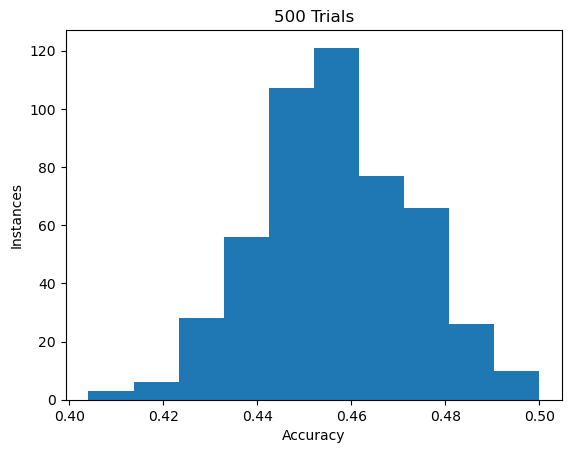

# Begin Neural Network Model

In [25]:
import keras

#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
#from tensorflow.keras.layers import Conv2D, MaxPooling2D

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt


ERROR! Session/line number was not unique in database. History logging moved to new session 489


In [26]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

In [33]:
y_train = keras.utils.to_categorical(le.fit_transform(y_test), 6)
#y_test = keras.utils.to_categorical(y_test, 6)

In [35]:
y_train


array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [34]:
oh = OneHotEncoder()
oh.fit_transform(y_train.reshape(-1,1))

<3564x2 sparse matrix of type '<class 'numpy.float64'>'
	with 3564 stored elements in Compressed Sparse Row format>

In [29]:
from sklearn.preprocessing import LabelEncoder

ERROR! Session/line number was not unique in database. History logging moved to new session 490


In [31]:
le = LabelEncoder()

In [32]:
le.fit_transform(y_test)

array([1, 1, 2, 4, 1, 4, 3, 4, 2, 0, 0, 3, 3, 0, 4, 2, 5, 2, 4, 2, 1, 0,
       0, 1, 0, 3, 4, 0, 2, 0, 3, 0, 5, 3, 1, 3, 1, 2, 5, 5, 1, 0, 4, 4,
       1, 3, 4, 1, 5, 4, 3, 5, 5, 4, 4, 5, 5, 5, 3, 3, 4, 2, 3, 5, 4, 5,
       4, 4, 2, 0, 5, 0, 5, 2, 5, 3, 4, 4, 4, 5, 2, 3, 4, 1, 5, 0, 1, 2,
       5, 3, 3, 0, 0, 0, 3, 5, 2, 3, 0, 5, 3, 2, 5, 0, 5, 3, 1, 0, 4, 3,
       1, 4, 4, 0, 3, 3, 3, 1, 4, 5, 0, 0, 3, 5, 3, 5, 4, 3, 3, 2, 0, 2,
       5, 1, 1, 5, 4, 1, 0, 4, 1, 1, 3, 3, 4, 2, 2, 1, 2, 3, 0, 4, 2, 1,
       2, 2, 0, 4, 3, 5, 5, 3, 2, 2, 0, 1, 5, 4, 3, 4, 1, 4, 3, 3, 5, 3,
       3, 2, 0, 4, 1, 4, 4, 0, 4, 4, 2, 5, 0, 4, 3, 3, 2, 0, 3, 3, 0, 3,
       2, 0, 5, 5, 2, 2, 3, 2, 5, 0, 4, 3, 0, 1, 4, 2, 2, 2, 5, 2, 1, 2,
       1, 4, 1, 3, 5, 5, 3, 3, 0, 2, 5, 3, 3, 4, 3, 3, 4, 2, 4, 2, 5, 2,
       5, 2, 5, 0, 1, 5, 3, 1, 5, 0, 2, 4, 5, 5, 3, 0, 2, 1, 4, 2, 1, 2,
       3, 5, 2, 2, 4, 2, 1, 5, 4, 0, 3, 3, 2, 0, 1, 1, 3, 5, 0, 5, 1, 1,
       0, 5, 2, 0, 2, 2, 1, 4, 2, 2, 3, 5, 2, 5, 1,

ERROR! Session/line number was not unique in database. History logging moved to new session 491
